In [1]:
import functools
import torch.nn as nn
from torchvision.models import squeezenet1_1
import torch

class SqueezeNet(nn.Module):
    def __init__(self, n_class=2):
        super(SqueezeNet, self).__init__()
        self.n_class = n_class
        self.base_model = squeezenet1_1(pretrained=True)
        temp = squeezenet1_1(pretrained=False, num_classes=n_class)
        self.base_model.classifier = temp.classifier
        del temp

    def forward(self, x):
        return self.base_model(x)


class StainNet(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, n_layer=3, n_channel=32, kernel_size=1):
        super(StainNet, self).__init__()
        model_list = []
        model_list.append(nn.Conv2d(input_nc, n_channel, kernel_size=kernel_size, bias=True, padding=kernel_size // 2))
        model_list.append(nn.ReLU(True))
        for n in range(n_layer - 2):
            model_list.append(
                nn.Conv2d(n_channel, n_channel, kernel_size=kernel_size, bias=True, padding=kernel_size // 2))
            model_list.append(nn.ReLU(True))
        model_list.append(nn.Conv2d(n_channel, output_nc, kernel_size=kernel_size, bias=True, padding=kernel_size // 2))

        self.rgb_trans = nn.Sequential(*model_list)

    def forward(self, x):
        return self.rgb_trans(x)


class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.

    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6,
                 padding_type='reflect'):
        """Construct a Resnet-based generator

        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert (n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):  # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout,
                                  use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block

        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.

        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not

        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

In [13]:
model_GAN = ResnetGenerator(3, 3, ngf=64, norm_layer=torch.nn.InstanceNorm2d, n_blocks=9).cuda()
model_GAN.load_state_dict(torch.load('latest_net_G_A.pth'))

/tmp/ipykernel_2826788/853109420.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_GAN.load_state_dict(torch.load('latest_net_G_A.pth'))


<All keys matched successfully>

In [8]:
def un_norm(image):
    image = image.cpu().detach().numpy()[0]
    image = ((image * 0.5 + 0.5) * 255).astype(np.uint8).transpose((1,2,0))
    return image

In [35]:
from pathlib import Path
import os
import random
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from DLMI_histopathology.models import HistoClassifierHead
from DLMI_histopathology.dataset import BaselineDataset, PrecomputedDataset,precompute
base_path = Path(os.getcwd())
print(f"{base_path=}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Working on {device}.')

TRAIN_IMAGES_PATH = base_path / 'train.h5'
VAL_IMAGES_PATH = base_path / 'val.h5'
TEST_IMAGES_PATH =base_path / 'test.h5'
SEED = 0

torch.random.manual_seed(SEED)
random.seed(SEED)

# Create the normalization transform
transform = transforms.Compose([
            transforms.Resize((98, 98)),
        ])

train_dataset = BaselineDataset(TRAIN_IMAGES_PATH, transform, 'train')
val_dataset = BaselineDataset(VAL_IMAGES_PATH, transform, 'train')


base_path=PosixPath('/raid/home/detectionfeuxdeforet/caillaud_gab/dlmi')
Working on cuda.


/raid/home/detectionfeuxdeforet/caillaud_gab/dlmi/DLMI_histopathology/dataset.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  img = torch.tensor(hdf.get(img_id).get('img'))


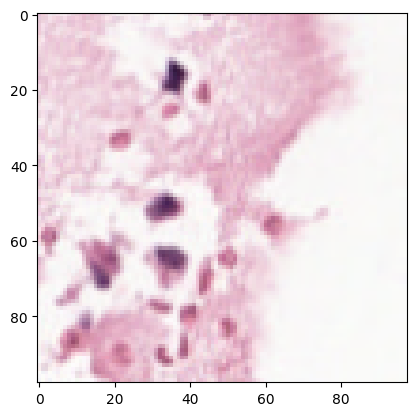

In [3]:
img = train_dataset[0][0]

import matplotlib.pyplot as plt
plt.imshow(img.permute(1,2,0))

In [18]:
print(img.min())
print(img.max())

tensor(0.0931)
tensor(0.9985)


In [11]:
test_img = (img - 0.5)/0.5
print(test_img.min())
print(test_img.max())

tensor(-0.8138)
tensor(0.9971)


In [4]:
def normalize_img(img):
    return (img - 0.5)/0.5

def unnormalize_img(img):
    return img * 0.5 + 0.5

Text(0.5, 1.0, 'StainGAN')

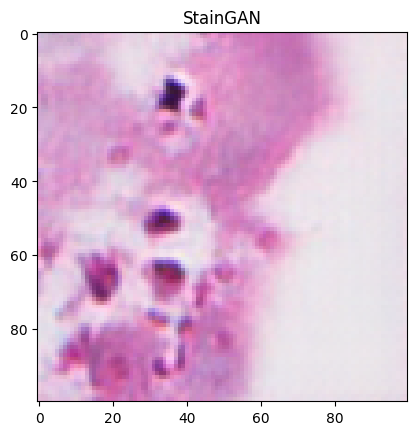

In [14]:
model_GAN.eval()
with torch.no_grad():
    img_gan=model_GAN(normalize_img(img).cuda())
img_gan=unnormalize_img(img_gan)
plt.imshow(img_gan.permute(1,2,0).cpu().numpy())
plt.title('StainGAN')

In [27]:
# dino
feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
feature_extractor.eval()

Using cache found in /raid/home/detectionfeuxdeforet/caillaud_gab/.cache/torch/hub/facebookresearch_dinov2_main
/raid/home/detectionfeuxdeforet/caillaud_gab/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/raid/home/detectionfeuxdeforet/caillaud_gab/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/raid/home/detectionfeuxdeforet/caillaud_gab/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [13]:
res = feature_extractor(transform(img_gan).unsqueeze(0))
res.shape

torch.Size([1, 768])

In [24]:

def precompute_StainGan(dataloader, model, device):
    xs, ys = [], []
    for x, y in tqdm(dataloader, leave=False):
        with torch.no_grad():
            x = normalize_img(x)
            res = model(x.to(device))
            res = unnormalize_img(res)
            # shape
            res = transform(res)
            res = feature_extractor(res).cpu().numpy()
            xs.append(res)
        ys.append(y.numpy())
    xs = np.vstack(xs)
    ys = np.hstack(ys)
    return torch.tensor(xs), torch.tensor(ys)

In [12]:
from tqdm import tqdm

In [7]:
from torch.utils.data import Dataset, DataLoader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)

In [8]:
import numpy as np

In [28]:
train_dataset = PrecomputedDataset(*precompute_StainGan(train_dataloader, model_GAN, device))

In [29]:

torch.save({
    'features': train_dataset.features,
    'labels': train_dataset.labels
}, 'train_dataset_staingan_dino.pt')


In [31]:
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=64)

In [32]:
val_dataset = PrecomputedDataset(*precompute_StainGan(val_dataloader, model_GAN, device))

In [33]:
torch.save({
    'features': val_dataset.features,
    'labels': val_dataset.labels
}, 'val_dataset_staingan_dino.pt')

In [9]:
test_train_dataset = torch.load('train_dataset_staingan_dino.pt')

/tmp/ipykernel_2733359/3784951315.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_train_dataset = torch.load('train_dataset_staingan_dino.pt')


In [36]:
test_train_dataset

{'features': tensor([[ 0.8096,  2.1053, -0.0899,  ..., -0.5274,  0.6502, -1.7491],
         [ 1.4518,  1.0150, -0.4543,  ..., -0.0158,  0.1109, -2.3612],
         [ 1.1491,  0.8672,  2.1072,  ...,  0.9158, -1.2362, -1.3873],
         ...,
         [ 0.6765,  3.1428,  1.9253,  ...,  1.5514,  0.7565, -1.3489],
         [ 1.4224, -0.8203, -1.2089,  ...,  0.6918,  1.6657, -0.0492],
         [ 2.2326, -0.0466,  1.5521,  ..., -1.0185, -0.0129, -1.5573]]),
 'labels': tensor([[1],
         [0],
         [0],
         ...,
         [1],
         [0],
         [1]])}

In [37]:
test_train_dataset['labels'].shape

torch.Size([100000, 1])

In [10]:
def precompute_StainGan_only(dataloader, model, device):
    xs, ys = [], []
    for x, y in tqdm(dataloader, leave=False):
        with torch.no_grad():
            x = normalize_img(x)
            res = model(x.to(device))
            res = unnormalize_img(res)
            # shape
            res = transform(res).cpu().numpy()
            xs.append(res)
        ys.append(y.numpy())
    xs = np.vstack(xs)
    ys = np.hstack(ys)
    return torch.tensor(xs), torch.tensor(ys)

In [13]:
train_dataset_stain_gan_only = PrecomputedDataset(*precompute_StainGan_only(train_dataloader, model_GAN, device))

  0%|          | 0/1563 [00:00<?, ?it/s]/raid/home/detectionfeuxdeforet/caillaud_gab/dlmi/DLMI_histopathology/dataset.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  img = torch.tensor(hdf.get(img_id).get('img'))


: 

: 

: 

In [1]:
torch.save(train_dataset_stain_gan_only, "train_dataset_stain_gan_only.pt")

NameError: name 'torch' is not defined

### StainNET

In [5]:
# load  pretrained StainNet
model_Net = StainNet().cuda()
model_Net.load_state_dict(torch.load("StainNet-Public_layer3_ch32.pth"))

/tmp/ipykernel_2826788/3669844602.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_Net.load_state_dict(torch.load("StainNet-Public_layer3_ch32.pth"))


<All keys matched successfully>

In [6]:
model_Net

StainNet(
  (rgb_trans): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.029024184..0.9058659].


Text(0.5, 1.0, 'StainNet')

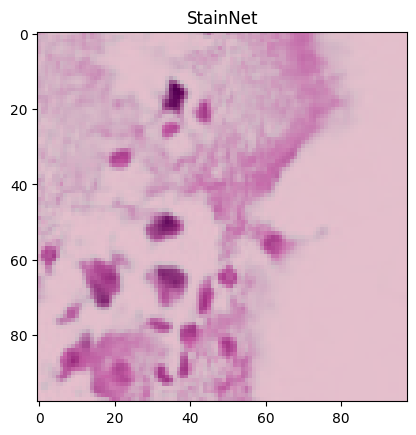

In [10]:
model_Net.eval()
with torch.no_grad():
    img_stainnet=model_Net(img.cuda())
# img_stainnet=unnormalize_img(img_stainnet)
plt.imshow(img_stainnet.permute(1,2,0).cpu().numpy())
plt.title('StainNet')

Text(0.5, 1.0, 'StainNet')

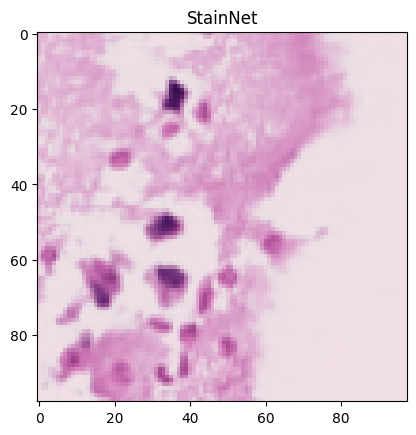

In [11]:
model_Net.eval()
with torch.no_grad():
    img_stainnet=model_Net(normalize_img(img).cuda())
img_stainnet=unnormalize_img(img_stainnet)
plt.imshow(img_stainnet.permute(1,2,0).cpu().numpy())
plt.title('StainNet')

In [22]:
import numpy as np

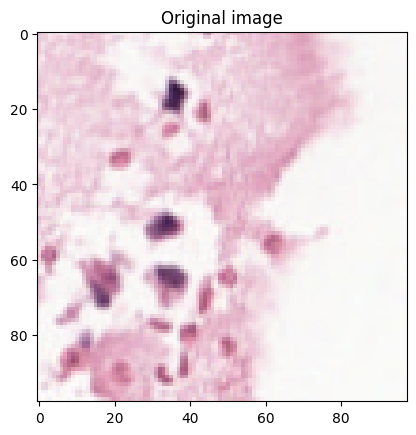

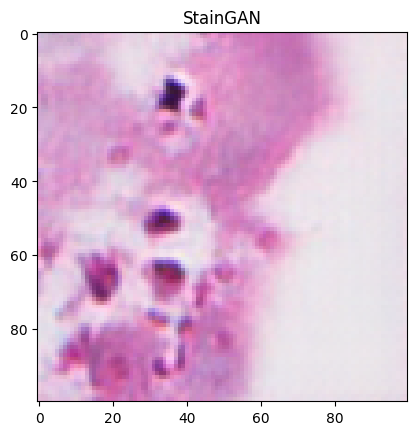

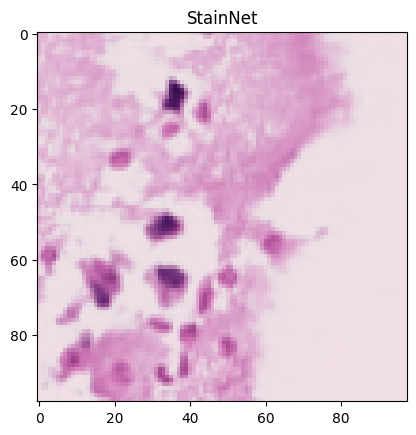

In [15]:
plt.imshow(img.permute(1,2,0))
plt.title("Original image")
plt.show()
plt.imshow(img_gan.permute(1,2,0).cpu().numpy())
plt.title('StainGAN')
plt.show()
plt.imshow(img_stainnet.permute(1,2,0).cpu().numpy())
plt.title('StainNet')
plt.show()

In [26]:
feature_extractor

NameError: name 'feature_extractor' is not defined

In [28]:
import torch
from torch import nn
from copy import deepcopy

class DinoFeatureExtractor(nn.Module):
    def __init__(self, dino_model, split_at=11):
        super().__init__()
        self.patch_embed = dino_model.patch_embed
        self.blocks = nn.Sequential(*dino_model.blocks[:split_at])  # up to block 10
        self.norm = nn.Identity()  # skip final norm for now

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.blocks(x)
        return x

In [29]:
dino_feature_extractor_body = DinoFeatureExtractor(feature_extractor)

In [30]:
dino_feature_extractor_body

DinoFeatureExtractor(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): Sequential(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1): NestedTe

In [43]:
feature_extractor

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [37]:
import torchvision.transforms as T

image_size=(98,98)

print("Using StainNet statisitcs on center 3")
mean = [0.6715, 0.3569, 0.5937]
std = [0.1269, 0.1916, 0.1157]

dino_normalize = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Normalize(mean=mean, std=std)
])

def preprocess_stain_and_normalize(images):
    with torch.no_grad():
        stained = model_Net(images.cuda())  # Apply StainNet
    stained = stained.clamp(0, 1)  # Just to be safe

    normalized = torch.stack([dino_normalize(img) for img in stained])
    return normalized

Using StainNet statisitcs on center 3


In [38]:
from tqdm import tqdm

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
all_features = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(train_dataloader):
        imgs = preprocess_stain_and_normalize(imgs)
        feats = dino_feature_extractor_body(imgs)  # Extract features from DINO
        all_features.append(feats.cpu())
        all_labels.append(labels)

all_features = torch.cat(all_features)
all_labels = torch.cat(all_labels)

torch.save((all_features, all_labels), 'train_stainnet_dino_features_block10.pt')

 68%|██████▊   | 1068/1563 [10:27<04:51,  1.70it/s]

: 

: 

: 

In [20]:
%run DLMI_histopathology/temp.py

Starting feature extraction...
Working on cuda.
Using StainNet statisitcs on center 3


/raid/home/detectionfeuxdeforet/caillaud_gab/dlmi/DLMI_histopathology/temp.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stainet.load_state_dict(torch.load("StainNet-

len(train_dataloader)=1563


0it [00:00, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

: 

: 

: 

## comparaison des stats des centres après stainnet

In [4]:
from torch.utils.data import Dataset, DataLoader
class BaselineDatasetCenter(Dataset):
    def __init__(self, dataset_path, preprocessing, mode,center):
        super(BaselineDatasetCenter, self).__init__()
        self.dataset_path = dataset_path
        self.preprocessing = preprocessing
        self.mode = mode
        self.image_ids=[]
        with h5py.File(self.dataset_path, 'r') as hdf:        
            indx = np.array(list(hdf.keys()))
            for indexes in indx:
                centers_nb=int(hdf.get(indexes).get("metadata")[0])
                if centers_nb==center:
                    self.image_ids.append(indexes)


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        with h5py.File(self.dataset_path, 'r') as hdf:
            img = torch.tensor(np.array(hdf.get(img_id).get('img')))
            label = np.array(hdf.get(img_id).get('label')) if self.mode == 'train' else None
        return self.preprocessing(img).float(), label

In [6]:
import h5py
import torch
import random
import numpy as np
import pandas as pd
import torchmetrics
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
preprocessing = transforms.Resize((98, 98))
train_set_3=BaselineDatasetCenter(TRAIN_IMAGES_PATH,preprocessing,"train",3)
train_set_4=BaselineDatasetCenter(TRAIN_IMAGES_PATH,preprocessing,"train",4)
train_set_0=BaselineDatasetCenter(TRAIN_IMAGES_PATH,preprocessing,"train",0)
train_loader_3=DataLoader(train_set_3,shuffle=False,batch_size=256)
train_loader_4=DataLoader(train_set_4,shuffle=False,batch_size=256)
train_loader_0=DataLoader(train_set_0,shuffle=False,batch_size=256)

In [7]:
def compute_stats(loader):
    mean=torch.zeros(3).to(device)
    std=torch.zeros(3).to(device)
    for data,lab in loader:
        mean+=torch.mean(data.to(device),dim=[0,2,3]).to(device)
        std+=torch.std(data.to(device),dim=[0,2,3]).to(device)   
    return mean/len(loader), std/len(loader)

In [8]:
def normalize_img(img):
    return (img - 0.5)/0.5

def unnormalize_img(img):
    return img * 0.5 + 0.5 

In [10]:
stainet = StainNet().cuda()
stainet.load_state_dict(torch.load("StainNet-Public_layer3_ch32.pth"))
stainet.eval()

/tmp/ipykernel_2876107/1359117897.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stainet.load_state_dict(torch.load("StainNet-Public_layer3_ch32.pth"))


StainNet(
  (rgb_trans): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [11]:
def preprocess_stain_and_normalize(images):
    with torch.no_grad():
        images = normalize_img(images)
        stained = stainet(images.cuda())  # Apply StainNet
    stained = unnormalize_img(stained)
    
    return preprocessing(stained)

In [19]:
def compute_stats_stainNet(loader):
    mean=torch.zeros(3).to(device)
    std=torch.zeros(3).to(device)
    print(f"{len(loader)=}")
    for i,(data,lab) in enumerate(loader):
        print(i)
        data = preprocess_stain_and_normalize(data.to(device))
        mean+=torch.mean(data,dim=[0,2,3])
        std+=torch.std(data,dim=[0,2,3]) 
    return mean.cpu()/len(loader), std.cpu()/len(loader)

In [20]:
compute_stats_stainNet(train_loader_3)

len(loader)=152
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151


(tensor([0.6708, 0.4186, 0.6388]), tensor([0.1809, 0.2079, 0.1446]))

In [21]:
compute_stats_stainNet(train_loader_0)

len(loader)=70
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


(tensor([0.7304, 0.5360, 0.7039]), tensor([0.1638, 0.2102, 0.1391]))

In [22]:
compute_stats_stainNet(train_loader_4)

len(loader)=170
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169


(tensor([0.8025, 0.6298, 0.7757]), tensor([0.0971, 0.1503, 0.0837]))

In [ ]:
val_dataset= BaselineDataset(VAL_IMAGES_PATH,preprocessing,"train")
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=512)

In [25]:
compute_stats_stainNet(val_loader)

len(loader)=69


/raid/home/detectionfeuxdeforet/caillaud_gab/dlmi/DLMI_histopathology/dataset.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  img = torch.tensor(hdf.get(img_id).get('img'))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


(tensor([0.6173, 0.3986, 0.6104]), tensor([0.1675, 0.2001, 0.1393]))

In [33]:
# statistics center 3
mean = [0.6708, 0.4186, 0.6388]
std = [0.1809, 0.2079, 0.1446]
image_size = (98,98)
after_stainnet_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Normalize(mean=mean, std=std),
])

In [34]:
def preprocess_stain_and_normalize(images):
    with torch.no_grad():
        images = normalize_img(images)
        stained = stainet(images.cuda())  # Apply StainNet
    stained = unnormalize_img(stained)
    
    return after_stainnet_transform(stained)

In [ ]:
test_dataset = BaselineDataset(TEST_IMAGES_PATH, transform, 'test')

In [37]:
import h5py
train_dataloader = DataLoader(val_dataset, shuffle="False", batch_size=256)
total_samples = len(train_dataloader.dataset)
print(f"{total_samples=}")
train_dataset_path = Path("val_stainnet_dino_features_block10.h5")
with h5py.File(train_dataset_path, 'w') as f:
    features_ds = f.create_dataset("features", shape=(total_samples, 49, 384), dtype='float32')
    labels_ds = f.create_dataset("labels", shape=(total_samples,), dtype='int64')
    index = 0
    with torch.no_grad():
        for i, (imgs, labels) in tqdm(enumerate(train_dataloader)):
            print(i)
            imgs = preprocess_stain_and_normalize(imgs)
            feats = dino_feature_extractor_body(imgs)  
            b = imgs.shape[0]
            features_ds[index:index + b] = feats.cpu().numpy()
            labels_ds[index:index + b] = labels.numpy()
            index += b

total_samples=34904


0it [00:00, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136


In [ ]:
import h5py
train_dataloader = DataLoader(val_dataset, shuffle="False", batch_size=256)
total_samples = len(train_dataloader.dataset)
print(f"{total_samples=}")
train_dataset_path = Path("val_stainnet_dino_features_block10.h5")
with h5py.File(train_dataset_path, 'w') as f:
    features_ds = f.create_dataset("features", shape=(total_samples, 49, 384), dtype='float32')
    labels_ds = f.create_dataset("labels", shape=(total_samples,), dtype='int64')
    index = 0
    with torch.no_grad():
        for i, (imgs, labels) in tqdm(enumerate(train_dataloader)):
            print(i)
            imgs = preprocess_stain_and_normalize(imgs)
            feats = dino_feature_extractor_body(imgs)  
            b = imgs.shape[0]
            features_ds[index:index + b] = feats.cpu().numpy()
            labels_ds[index:index + b] = labels.numpy()
            index += b

In [ ]:
def compute_stain_dino_dataset(loader, path):
  
    labels = 
    print(f"{len(loader)=}")
    for i,(data,lab) in enumerate(loader):
        print(i)
        data = preprocess_stain_and_normalize(data.to(device))
       
    return 

In [ ]:
%run DLMI_histopathology/stainet_dino_last_layer_finetune.py

base_path=PosixPath('/raid/home/detectionfeuxdeforet/caillaud_gab/dlmi')
test
__main__
Working on cuda.
Using StainNet statisitcs on center 3
Dataset created


Using cache found in /raid/home/detectionfeuxdeforet/caillaud_gab/.cache/torch/hub/facebookresearch_dinov2_main


1805889
Starting training
len(train_dataloader)=1563
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
2

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [1/100] Train Loss: 0.3377 | Train Metric 0.8614 Val Loss: 0.5115 Val Metric 0.7740
New best loss inf -> 0.5115
len(train_dataloader)=1563
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
2

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [2/100] Train Loss: 0.2767 | Train Metric 0.8897 Val Loss: 0.4803 Val Metric 0.8039
New best loss 0.5115 -> 0.4803
len(train_dataloader)=1563
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
24

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [3/100] Train Loss: 0.2504 | Train Metric 0.9019 Val Loss: 0.5723 Val Metric 0.7721
len(train_dataloader)=1563
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
2

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [4/100] Train Loss: 0.2309 | Train Metric 0.9103 Val Loss: 0.4916 Val Metric 0.8178
len(train_dataloader)=1563
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
2

In [ ]:
%run DLMI_histopathology/stainet_dino_last_layer_finetune.py

test
__main__
Working on cuda.
Using StainNet statisitcs on center 3
Dataset created


Using cache found in /raid/home/detectionfeuxdeforet/caillaud_gab/.cache/torch/hub/facebookresearch_dinov2_main


1805889
Evaluating model on test data


/raid/home/detectionfeuxdeforet/caillaud_gab/dlmi/DLMI_histopathology/stainet_dino_last_layer_finetune.py:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stainet.load_sta

  0%|          | 0/85054 [00:00<?, ?it/s]